This notebook demonstrates the process of implementing logistic regression from scratch using gradient descent.
The dataset used is the Wine Dataset from the UCI Machine Learning Repository. This dataset contains the results of
a chemical analysis of wines grown in the same region in Italy by three different cultivators. There are 13 different
measurements taken for different constituents found in the three types of wine.

We will be focusing on using 'alcohol' and 'ash' as features to predict the 'class' of the wine.
However, the implementation will be generalizable to use any number of features.

In [29]:
# Import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import ListedColormap


First, we will load the wine dataset using Pandas, selecting 'alcohol' and 'ash' as our features and 'class' as our target.


In [30]:
# Load dataset
engine = create_engine('sqlite:///../data/data.sqlite')

query_training_data = """SELECT * FROM (select DPLZ4 as ZIP,
             GBAUJ,
             GAREA * GASTW as FlAECHE,
             GWAERZH1,
             w1.CODTXTLD   as GWAERZH1TXT,
             GENH1,
             c1.CODTXTLD   as GENH1TXT,
             GWAERDATH1
      from building b,
           entrance e,
           (select CECODID, CODTXTLD from codes WHERE CMERKM = 'GWAERZH1') w1,
           (select CECODID, CODTXTLD from codes WHERE CMERKM = 'GENH1') c1
      WHERE b.GABBJ == ''
        AND (GENH1 NOT IN ('', '7500', '7598') OR GENH2 NOT IN ('', '7500', '7598'))
        AND b.GWAERZH1 = w1.CECODID
        AND b.GENH1 = c1.CECODID
        AND e.EGID = b.EGID
        AND (GSTAT NOT in ('1005', '1007', '1008'))) LIMIT 10"""

df_original = pd.read_sql_query(query_training_data, engine)
le = LabelEncoder()
df_original['CATEGORY'] = le.fit_transform(df_original['GENH1'])
print(df_original.head())

df = df_original.drop(columns=['ZIP', 'GWAERZH1', 'GWAERZH1TXT', 'GENH1', 'GENH1TXT', 'GWAERDATH1'])

df['GBAUJ'] = pd.to_numeric(df['GBAUJ'], errors='coerce') / 2050
df['FlAECHE'] = df['FlAECHE'] / 1000

# Separate features and target
X = df[['GBAUJ', 'FlAECHE']].values
y = df['CATEGORY'].values

# Convert class labels to binary (class 1 vs others class)
y = (y == 1).astype(int)

# Add intercept term
X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_train)
print(y_train)


    ZIP GBAUJ  FlAECHE GWAERZH1                                 GWAERZH1TXT  \
0  8914  2000      498     7410                  Wärmepumpe für ein Gebäude   
1  8914  2000      180     7430      Heizkessel (generisch) für ein Gebäude   
2  8914  1993      216     7431  Heizkessel (generisch) für mehrere Gebäude   
3  8914  1845      495     7430      Heizkessel (generisch) für ein Gebäude   
4  8914  1900      626     7436                                        Ofen   

  GENH1       GENH1TXT  GWAERDATH1  CATEGORY  
0  7511  Erdwärmesonde  2023-10-02         0  
1  7530         Heizöl  2002-09-05         1  
2  7530         Heizöl  2002-09-05         1  
3  7530         Heizöl  2001-11-29         1  
4  7530         Heizöl  2014-01-14         1  
[[1.         0.97560976 0.498     ]
 [1.         0.96926829 0.111     ]
 [1.         0.96878049 0.096     ]
 [1.         0.96926829 0.618     ]
 [1.         0.97560976 0.18      ]
 [1.         0.92682927 0.626     ]
 [1.         0.9        0.4

With our data loaded, we now define the necessary functions for logistic regression:

- **Sigmoid Function**: This function maps any real-valued number into the range of 0 to 1, which is useful when our outcome is binary.

- **Cost Function**: Also known as the log-loss or binary cross-entropy loss, measures the performance of our model. It quantifies the difference between the predicted values and the actual values.

- **Gradient Function**: This computes the gradient of the cost function. The gradient is used to update the parameters.

- **Gradient Descent Function**: This function iteratively adjusts the parameters to minimize the cost function.

- **Prediction Function**: Generates predictions based on learned model parameters by applying a threshold of 0.5.
"""

In [31]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))



In [32]:
from scipy.optimize import fmin_tnc
from sklearn import metrics
# Define the logistic regression cost function. Note that we use vectorization, and theta includes theta_0, theta_1, etc.
def log_reg_cost_function(theta, X, y):
    m = X.shape[0]  # number of training examples
    h = sigmoid(X.dot(theta))
    cost = (-1 / m) * (y.T.dot(np.log(h)) + (1 - y).T.dot(np.log(1 - h)))
    return cost

# Define the gradient of the logistic regression cost function
def log_reg_gradient_function(theta, X, y):
    m = X.shape[0]  # number of training examples
    h = sigmoid(X.dot(theta))
    gradient = (1 / m) * (X.T.dot(h - y))
    return gradient

# Define the function to train logistic regression model
def log_reg_train_function(X, y):
    # Add intercept term to X
    X_with_intercept = np.insert(X, 0, 1, axis=1)
    # Initial theta is 0 (n+1) dimensions, where n is number of features
    initial_theta = np.zeros(X_with_intercept.shape[1])
    # Optimize the cost function (note that we use a solver, or optimizer, called fmin_tnc)
    theta, _, _ = fmin_tnc(func=log_reg_cost_function, x0=initial_theta,
                            fprime=log_reg_gradient_function, args=(X_with_intercept, y))
    return theta

In [33]:
# Train the model using the defined function
theta = log_reg_train_function(X_train, y_train)

print(theta)

# Make predictions on the test set by using the optimal theta resulting from running gradient descent on the cost gradients
X_test_with_intercept = np.insert(X_test, 0, 1, axis=1)
y_pred = (sigmoid(X_test_with_intercept.dot(theta)) >= 0.5).astype(int)

# Calculate performance metrics
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = metrics.recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = metrics.f1_score(y_test, y_pred, average='weighted', zero_division=1)
cm = metrics.confusion_matrix(y_test, y_pred)

accuracy, precision, recall, f1, cm

[  63.03788503   63.03788503 -129.37629978    0.20630735]


  NIT   NF   F                       GTG
    0    1  6.931471805599453E-01   1.41797295E-01
    1    4  5.781246462422103E-01   1.05455944E-03
tnc: fscale = 30.7939
    2    7  5.751706634902052E-01   2.30853206E-05
    3   10  5.651457443570219E-01   7.72616795E-03
tnc: stepmx = 1000
    4   13  5.387696643219502E-01   4.95948405E-03
    5   19  4.983460966797240E-01   1.90513730E-02
    6   22  4.703740660915092E-01   5.97272421E-04
    7   25  4.691944420480560E-01   1.44742176E-05
    8   28  4.684599688689814E-01   5.77269226E-07
tnc: fscale = 1316.17
    9   31  4.684588881816934E-01   3.18030106E-11
tnc: fscale = 177323
   10   34  4.684582517820441E-01   8.58729956E-09
   11   37  4.684488774938501E-01   3.28029863E-11
tnc: |fn-fn-1] = 2.47028e-09 -> convergence
   12   40  4.684488750235706E-01   4.42372770E-16
tnc: Converged (|f_n-f_(n-1)| ~= 0)


(0.6666666666666666,
 0.7777777777777777,
 0.6666666666666666,
 0.5333333333333333,
 array([[0, 1],
        [0, 2]]))

Before training our model, let's visualize the data. We will plot the two features on a scatter plot, 
color-coding them by their respective class labels.

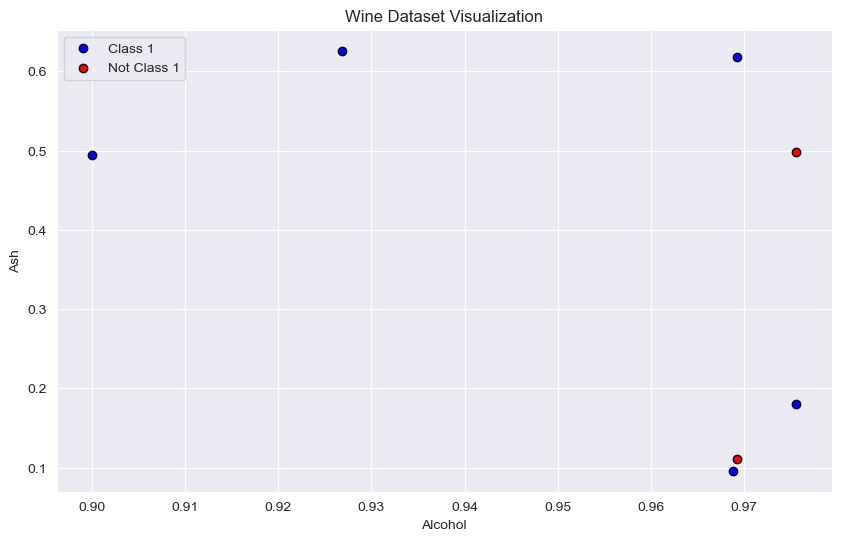

In [34]:
def plot_data(X, y, labels):
    plt.figure(figsize=(10, 6))
    plt.scatter(X[y == 1, 1], X[y == 1, 2], color='blue', label=labels[0], edgecolors='k')
    plt.scatter(X[y == 0, 1], X[y == 0, 2], color='red', label=labels[1], edgecolors='k')
    
    plt.xlabel('Alcohol')
    plt.ylabel('Ash')
    plt.legend()
    plt.grid(True)
    plt.title('Heating Type Visualization')
    plt.show()

plot_data(X_train, y_train, labels=['Class 1', 'Not Class 1'])

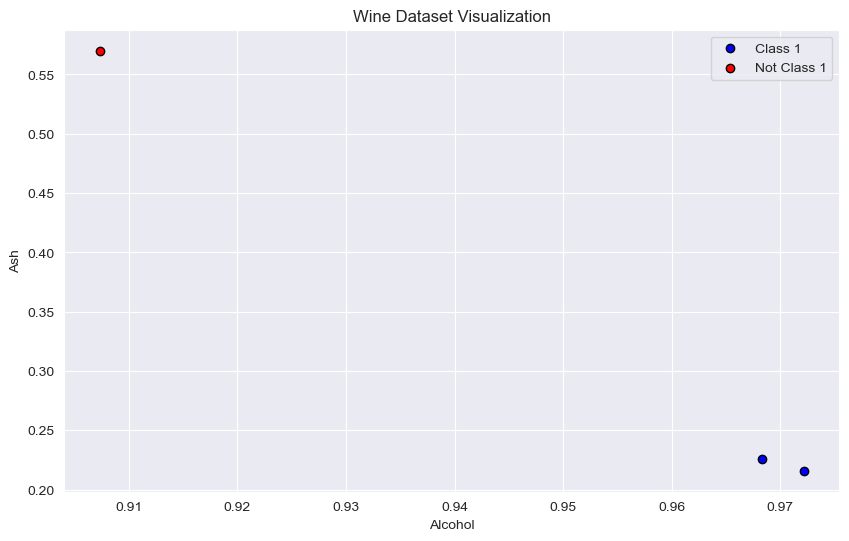

Text(0.5, 1.0, 'wrong predictions')

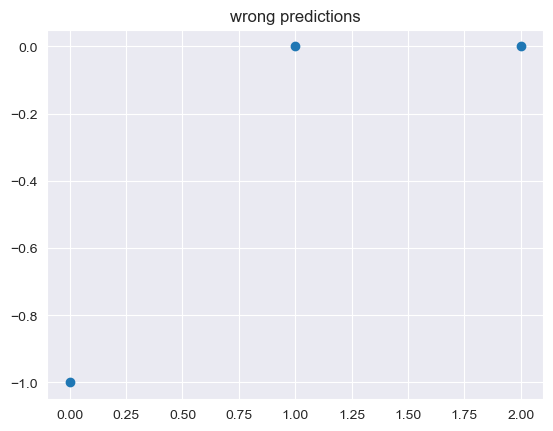

In [35]:
plot_data(X_test, y_test, labels=['Class 1', 'Not Class 1'])


plt.plot(y_test-y_pred,'o')
plt.title('wrong predictions')



How can the model be improved? An easy way would be to add more features. Try this and report the accuracy.